In [1]:
# SETUP
import numpy as np
import tensorflow as tf
import random
from collections import deque
import matplotlib.pyplot as plt

import gym
env = gym.make('CartPole-v0')
env._max_episode_steps = 10000

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

dis = 0.9
REPLAY_MEMORY = 10000
step_count_list = []

In [2]:
# NETWORK
class DQN:
    
    def __init__(self,session, input_size, output_size, name="main"):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        
        self._build_network()
    
    def _build_network(self, h_size=10, l_rate=1e-1):
        with tf.variable_scope(self.net_name):
            self._X = tf.placeholder(tf.float32, [None, self.input_size], name="input_x")
            
            # First layer of weights
            W1 = tf.get_variable("W1", shape=[self.input_size, h_size], 
                                initializer=tf.contrib.layers.xavier_initializer())
            layer1 = tf.nn.tanh(tf.matmul(self._X, W1))
            
            # Second layer of weights
            W2 = tf.get_variable("W2", shape=[h_size, self.output_size], 
                                initializer=tf.contrib.layers.xavier_initializer())
            
            # Q prediction
            self._Qpred = tf.matmul(layer1, W2)
            
        # We need to define the parts of the network needed for learnig a policy
        self._Y = tf.placeholder(
            shape=[None, self.output_size], dtype=tf.float32)
        
        # Loss function
        self._loss = tf.reduce_mean(tf.square(self._Y - self._Qpred))
        # Learning
        self._train = tf.train.AdamOptimizer(
            learning_rate= l_rate).minimize(self._loss)
    
    def predict(self, state):
        x = np.reshape(state, [1, self.input_size])
        return self.session.run(self._Qpred, feed_dict={self._X: x})
    
    def update(self, x_stack, y_stack):
        return self.session.run([self._loss, self._train], feed_dict={
            self._X: x_stack, self._Y: y_stack})

In [3]:
# Train from replay buffer
def replay_train(mainDQN, targetDQN, train_batch):
    x_stack = np.empty(0).reshape(0, input_size)
    y_stack = np.empty(0).reshape(0, output_size)
    
    # Get stored information from the buffer
    for state, action, reward, next_state, done in train_batch:
        Q = mainDQN.predict(state)
        
        # terminal?
        if done:
            Q[0, action] = reward
        else:
            # Obtain the Q' values by feeding the new state through network
            #Q[0, action] = reward + dis * np.max(targetDQN.predict(next_state))
            Q[0, action] = reward + dis*targetDQN.predict(next_state)[0, np.argmax(mainDQN.predict(next_state))]
        y_stack = np.vstack([y_stack, Q])
        x_stack = np.vstack([x_stack, state])
        
    # Train our network using target and predicted Q values on each episode
    return mainDQN.update(x_stack, y_stack)

In [4]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    # Copy variables src_scope to dest_scope
    op_holder = []
    
    src_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
    
    return op_holder

In [5]:
# bot play
def bot_play(mainDQN):
    # See our trained network in action
    s = env.reset()
    reward_sum = 0
    while True:
        env.render()
        a = np.argmax(mainDQN.predict(s))
        s, reward, done, _ = env.step(a)
        reward_sum += reward
        if done:
            print("Total score: {}".format(reward_sum))
            break

In [6]:
# main
def main():
    max_episodes = 3000
    
    # store the previous observations in replay memory
    replay_buffer = deque()
    
    with tf.Session() as sess:
        mainDQN = DQN(sess, input_size, output_size, name="main")
        targetDQN = DQN(sess, input_size, output_size, name="target")
        tf.global_variables_initializer().run()
        
        # initial copy q_net --> target_net
        copy_ops = get_copy_var_ops(dest_scope_name="target",
                                   src_scope_name="main")
        sess.run(copy_ops)
        
        for episode in range(max_episodes):
            e = 1. / ((episode / 10) + 1)
            done = False
            step_count = 0
            state = env.reset()
            
            while not done:
                if np.random.rand(1) < e:
                    action = env.action_space.sample()
                else:
                    # Choose an action by greedily from the Q_network
                    action = np.argmax(mainDQN.predict(state))
                
                # Get the state and reward from enviroment
                next_state, reward, done, _ = env.step(action)
                if done: # big penalty
                    reward = -100
                
                # Save the experience to our buffer
                replay_buffer.append((state, action, reward, next_state, done))
                if len(replay_buffer) > REPLAY_MEMORY:
                    replay_buffer.popleft()
                
                state = next_state
                step_count += 1
                if step_count > 10000:
                    break
                
            print("Episode: {} steps: {}".format(episode, step_count))
            step_count_list.append(step_count)
            
            if step_count >10000:
                pass
                # break
            
            if episode % 10 == 1: # train every 20 episode
                # Get a random batch of experiences.
                for _ in range(50):
                    minibatch = random.sample(replay_buffer, 10)
                    loss, _ = replay_train(mainDQN, targetDQN, minibatch)
                
                print("Loss: ", loss)
                # copy Q_net --> target_net
                sess.run(copy_ops)
            
        bot_play(mainDQN)

In [7]:
if __name__ == "__main__":
    main()

Episode: 0 steps: 12
Episode: 1 steps: 13
Loss:  5.74684
Episode: 2 steps: 11
Episode: 3 steps: 19
Episode: 4 steps: 20
Episode: 5 steps: 13
Episode: 6 steps: 10
Episode: 7 steps: 20
Episode: 8 steps: 9
Episode: 9 steps: 11
Episode: 10 steps: 11
Episode: 11 steps: 11
Loss:  6.98865
Episode: 12 steps: 89
Episode: 13 steps: 94
Episode: 14 steps: 33
Episode: 15 steps: 117
Episode: 16 steps: 157
Episode: 17 steps: 93
Episode: 18 steps: 35
Episode: 19 steps: 101
Episode: 20 steps: 146
Episode: 21 steps: 17
Loss:  5.24235
Episode: 22 steps: 228
Episode: 23 steps: 331
Episode: 24 steps: 506
Episode: 25 steps: 191
Episode: 26 steps: 477
Episode: 27 steps: 349
Episode: 28 steps: 301
Episode: 29 steps: 214
Episode: 30 steps: 237
Episode: 31 steps: 193
Loss:  3.74712
Episode: 32 steps: 33
Episode: 33 steps: 115
Episode: 34 steps: 85
Episode: 35 steps: 31
Episode: 36 steps: 40
Episode: 37 steps: 84
Episode: 38 steps: 42
Episode: 39 steps: 23
Episode: 40 steps: 105
Episode: 41 steps: 102
Loss:  532

Episode: 312 steps: 10000
Episode: 313 steps: 10000
Episode: 314 steps: 10000
Episode: 315 steps: 10000
Episode: 316 steps: 10000
Episode: 317 steps: 10000
Episode: 318 steps: 10000
Episode: 319 steps: 10000
Episode: 320 steps: 10000
Episode: 321 steps: 10000
Loss:  0.0164562
Episode: 322 steps: 10000
Episode: 323 steps: 10000
Episode: 324 steps: 10000
Episode: 325 steps: 10000
Episode: 326 steps: 10000
Episode: 327 steps: 10000
Episode: 328 steps: 10000
Episode: 329 steps: 10000
Episode: 330 steps: 10000
Episode: 331 steps: 10000
Loss:  0.00159291
Episode: 332 steps: 10000
Episode: 333 steps: 10000
Episode: 334 steps: 10000
Episode: 335 steps: 10000
Episode: 336 steps: 10000
Episode: 337 steps: 10000
Episode: 338 steps: 10000
Episode: 339 steps: 10000
Episode: 340 steps: 10000
Episode: 341 steps: 10000
Loss:  0.0644708
Episode: 342 steps: 10000
Episode: 343 steps: 10000
Episode: 344 steps: 10000
Episode: 345 steps: 10000
Episode: 346 steps: 10000
Episode: 347 steps: 10000
Episode: 348

Loss:  0.0791391
Episode: 612 steps: 1249
Episode: 613 steps: 25
Episode: 614 steps: 22
Episode: 615 steps: 52
Episode: 616 steps: 863
Episode: 617 steps: 34
Episode: 618 steps: 75
Episode: 619 steps: 26
Episode: 620 steps: 21
Episode: 621 steps: 24
Loss:  3.29348
Episode: 622 steps: 9
Episode: 623 steps: 10
Episode: 624 steps: 9
Episode: 625 steps: 10
Episode: 626 steps: 10
Episode: 627 steps: 10
Episode: 628 steps: 11
Episode: 629 steps: 10
Episode: 630 steps: 9
Episode: 631 steps: 10
Loss:  3.04887
Episode: 632 steps: 9
Episode: 633 steps: 9
Episode: 634 steps: 10
Episode: 635 steps: 10
Episode: 636 steps: 9
Episode: 637 steps: 10
Episode: 638 steps: 8
Episode: 639 steps: 10
Episode: 640 steps: 10
Episode: 641 steps: 8
Loss:  3.33569
Episode: 642 steps: 9
Episode: 643 steps: 10
Episode: 644 steps: 11
Episode: 645 steps: 10
Episode: 646 steps: 9
Episode: 647 steps: 9
Episode: 648 steps: 9
Episode: 649 steps: 8
Episode: 650 steps: 8
Episode: 651 steps: 10
Loss:  1.65699
Episode: 652 s

Loss:  0.399604
Episode: 942 steps: 91
Episode: 943 steps: 69
Episode: 944 steps: 138
Episode: 945 steps: 48
Episode: 946 steps: 116
Episode: 947 steps: 67
Episode: 948 steps: 110
Episode: 949 steps: 148
Episode: 950 steps: 101
Episode: 951 steps: 63
Loss:  3.22841
Episode: 952 steps: 54
Episode: 953 steps: 51
Episode: 954 steps: 83
Episode: 955 steps: 63
Episode: 956 steps: 100
Episode: 957 steps: 150
Episode: 958 steps: 74
Episode: 959 steps: 71
Episode: 960 steps: 62
Episode: 961 steps: 36
Loss:  5.50069
Episode: 962 steps: 11
Episode: 963 steps: 9
Episode: 964 steps: 10
Episode: 965 steps: 10
Episode: 966 steps: 10
Episode: 967 steps: 10
Episode: 968 steps: 9
Episode: 969 steps: 9
Episode: 970 steps: 9
Episode: 971 steps: 9
Loss:  6.29721
Episode: 972 steps: 25
Episode: 973 steps: 39
Episode: 974 steps: 37
Episode: 975 steps: 59
Episode: 976 steps: 41
Episode: 977 steps: 27
Episode: 978 steps: 19
Episode: 979 steps: 39
Episode: 980 steps: 36
Episode: 981 steps: 32
Loss:  3.64638
Ep

Episode: 1268 steps: 44
Episode: 1269 steps: 49
Episode: 1270 steps: 25
Episode: 1271 steps: 74
Loss:  2.20914
Episode: 1272 steps: 51
Episode: 1273 steps: 50
Episode: 1274 steps: 305
Episode: 1275 steps: 63
Episode: 1276 steps: 39
Episode: 1277 steps: 49
Episode: 1278 steps: 56
Episode: 1279 steps: 205
Episode: 1280 steps: 185
Episode: 1281 steps: 185
Loss:  5.15402
Episode: 1282 steps: 12
Episode: 1283 steps: 14
Episode: 1284 steps: 8
Episode: 1285 steps: 11
Episode: 1286 steps: 13
Episode: 1287 steps: 13
Episode: 1288 steps: 11
Episode: 1289 steps: 15
Episode: 1290 steps: 11
Episode: 1291 steps: 11
Loss:  3.7082
Episode: 1292 steps: 25
Episode: 1293 steps: 25
Episode: 1294 steps: 48
Episode: 1295 steps: 34
Episode: 1296 steps: 34
Episode: 1297 steps: 29
Episode: 1298 steps: 59
Episode: 1299 steps: 46
Episode: 1300 steps: 39
Episode: 1301 steps: 42
Loss:  6.19663
Episode: 1302 steps: 47
Episode: 1303 steps: 59
Episode: 1304 steps: 59
Episode: 1305 steps: 50
Episode: 1306 steps: 43
Ep

Loss:  3.11669
Episode: 1592 steps: 33
Episode: 1593 steps: 34
Episode: 1594 steps: 76
Episode: 1595 steps: 36
Episode: 1596 steps: 35
Episode: 1597 steps: 35
Episode: 1598 steps: 44
Episode: 1599 steps: 28
Episode: 1600 steps: 34
Episode: 1601 steps: 28
Loss:  2.51898
Episode: 1602 steps: 28
Episode: 1603 steps: 51
Episode: 1604 steps: 41
Episode: 1605 steps: 53
Episode: 1606 steps: 25
Episode: 1607 steps: 38
Episode: 1608 steps: 66
Episode: 1609 steps: 66
Episode: 1610 steps: 27
Episode: 1611 steps: 63
Loss:  549.862
Episode: 1612 steps: 27
Episode: 1613 steps: 43
Episode: 1614 steps: 25
Episode: 1615 steps: 31
Episode: 1616 steps: 26
Episode: 1617 steps: 25
Episode: 1618 steps: 22
Episode: 1619 steps: 26
Episode: 1620 steps: 25
Episode: 1621 steps: 24
Loss:  478.17
Episode: 1622 steps: 23
Episode: 1623 steps: 26
Episode: 1624 steps: 26
Episode: 1625 steps: 35
Episode: 1626 steps: 21
Episode: 1627 steps: 23
Episode: 1628 steps: 28
Episode: 1629 steps: 32
Episode: 1630 steps: 47
Episo

Episode: 1917 steps: 42
Episode: 1918 steps: 45
Episode: 1919 steps: 36
Episode: 1920 steps: 31
Episode: 1921 steps: 38
Loss:  15.4526
Episode: 1922 steps: 56
Episode: 1923 steps: 22
Episode: 1924 steps: 31
Episode: 1925 steps: 21
Episode: 1926 steps: 31
Episode: 1927 steps: 23
Episode: 1928 steps: 33
Episode: 1929 steps: 28
Episode: 1930 steps: 29
Episode: 1931 steps: 43
Loss:  13.7706
Episode: 1932 steps: 40
Episode: 1933 steps: 39
Episode: 1934 steps: 43
Episode: 1935 steps: 26
Episode: 1936 steps: 38
Episode: 1937 steps: 43
Episode: 1938 steps: 32
Episode: 1939 steps: 38
Episode: 1940 steps: 42
Episode: 1941 steps: 31
Loss:  501.623
Episode: 1942 steps: 30
Episode: 1943 steps: 42
Episode: 1944 steps: 24
Episode: 1945 steps: 26
Episode: 1946 steps: 26
Episode: 1947 steps: 39
Episode: 1948 steps: 28
Episode: 1949 steps: 39
Episode: 1950 steps: 51
Episode: 1951 steps: 40
Loss:  2.51157
Episode: 1952 steps: 26
Episode: 1953 steps: 24
Episode: 1954 steps: 12
Episode: 1955 steps: 16
Epis

Loss:  2.76572
Episode: 2242 steps: 20
Episode: 2243 steps: 29
Episode: 2244 steps: 24
Episode: 2245 steps: 53
Episode: 2246 steps: 44
Episode: 2247 steps: 33
Episode: 2248 steps: 49
Episode: 2249 steps: 26
Episode: 2250 steps: 30
Episode: 2251 steps: 24
Loss:  0.494325
Episode: 2252 steps: 21
Episode: 2253 steps: 55
Episode: 2254 steps: 31
Episode: 2255 steps: 33
Episode: 2256 steps: 29
Episode: 2257 steps: 21
Episode: 2258 steps: 21
Episode: 2259 steps: 33
Episode: 2260 steps: 29
Episode: 2261 steps: 28
Loss:  1091.18
Episode: 2262 steps: 37
Episode: 2263 steps: 28
Episode: 2264 steps: 63
Episode: 2265 steps: 46
Episode: 2266 steps: 27
Episode: 2267 steps: 53
Episode: 2268 steps: 45
Episode: 2269 steps: 53
Episode: 2270 steps: 72
Episode: 2271 steps: 30
Loss:  535.524
Episode: 2272 steps: 8
Episode: 2273 steps: 10
Episode: 2274 steps: 10
Episode: 2275 steps: 8
Episode: 2276 steps: 9
Episode: 2277 steps: 10
Episode: 2278 steps: 8
Episode: 2279 steps: 11
Episode: 2280 steps: 9
Episode:

Episode: 2565 steps: 76
Episode: 2566 steps: 43
Episode: 2567 steps: 53
Episode: 2568 steps: 73
Episode: 2569 steps: 41
Episode: 2570 steps: 147
Episode: 2571 steps: 31
Loss:  4.97805
Episode: 2572 steps: 10
Episode: 2573 steps: 9
Episode: 2574 steps: 15
Episode: 2575 steps: 9
Episode: 2576 steps: 9
Episode: 2577 steps: 9
Episode: 2578 steps: 9
Episode: 2579 steps: 11
Episode: 2580 steps: 9
Episode: 2581 steps: 8
Loss:  2.56803
Episode: 2582 steps: 33
Episode: 2583 steps: 29
Episode: 2584 steps: 62
Episode: 2585 steps: 36
Episode: 2586 steps: 29
Episode: 2587 steps: 29
Episode: 2588 steps: 75
Episode: 2589 steps: 26
Episode: 2590 steps: 27
Episode: 2591 steps: 23
Loss:  2.5419
Episode: 2592 steps: 29
Episode: 2593 steps: 27
Episode: 2594 steps: 43
Episode: 2595 steps: 29
Episode: 2596 steps: 31
Episode: 2597 steps: 25
Episode: 2598 steps: 42
Episode: 2599 steps: 38
Episode: 2600 steps: 41
Episode: 2601 steps: 24
Loss:  4.83808
Episode: 2602 steps: 9
Episode: 2603 steps: 10
Episode: 260

Episode: 2891 steps: 51
Loss:  1048.66
Episode: 2892 steps: 41
Episode: 2893 steps: 35
Episode: 2894 steps: 36
Episode: 2895 steps: 29
Episode: 2896 steps: 65
Episode: 2897 steps: 39
Episode: 2898 steps: 40
Episode: 2899 steps: 78
Episode: 2900 steps: 35
Episode: 2901 steps: 39
Loss:  941.734
Episode: 2902 steps: 27
Episode: 2903 steps: 33
Episode: 2904 steps: 43
Episode: 2905 steps: 48
Episode: 2906 steps: 48
Episode: 2907 steps: 38
Episode: 2908 steps: 61
Episode: 2909 steps: 33
Episode: 2910 steps: 37
Episode: 2911 steps: 38
Loss:  8.74292
Episode: 2912 steps: 57
Episode: 2913 steps: 51
Episode: 2914 steps: 54
Episode: 2915 steps: 53
Episode: 2916 steps: 38
Episode: 2917 steps: 44
Episode: 2918 steps: 41
Episode: 2919 steps: 47
Episode: 2920 steps: 47
Episode: 2921 steps: 30
Loss:  8.82065
Episode: 2922 steps: 21
Episode: 2923 steps: 18
Episode: 2924 steps: 19
Episode: 2925 steps: 19
Episode: 2926 steps: 27
Episode: 2927 steps: 16
Episode: 2928 steps: 20
Episode: 2929 steps: 20
Epis

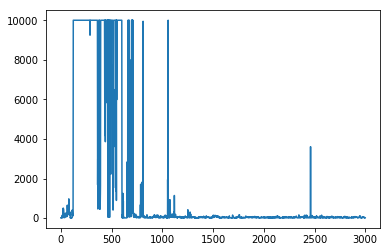

In [29]:
plt.plot(step_count_list)
plt.show()

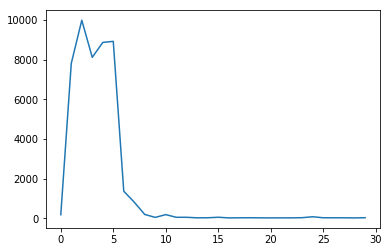

In [39]:
cnt = 0
a = 0
score_list_100 = []
for j in (step_count_list):
    cnt += 1
    a += j
    if cnt == 100:
        score_list_100.append(a/cnt)
        cnt = 0
        a = 0
plt.plot(score_list_100)
plt.xlabel("epoch: 1epoch = 100 episodes")
plt.ylabel("score")
plt.title("CartPole_DQN(2015)")
plt.show()

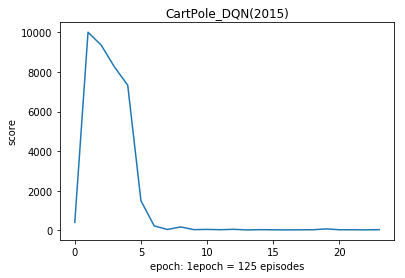

In [50]:
cnt = 0
a = 0
score_list_125 = []
for j in (step_count_list):
    cnt += 1
    a += j
    if cnt == 125:
        score_list_125.append(a/cnt)
        cnt = 0
        a = 0
plt.plot(score_list_125)
plt.xlabel("epoch: 1epoch = 125 episodes")
plt.ylabel("score")
plt.title("CartPole_DQN(2015)")
plt.show()